In [1]:
#import statements
import stochastic_error_model #future_stoch_mvnorm is the function we want to use
import numpy as np 
import pandas as pd
import math
import scipy.stats as st
from scipy.stats import norm
import statsmodels.tsa as tsa
import statsmodels.api as sm
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
cpal = sns.color_palette('Paired',11)
cpal

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6)]

In [3]:
fpath = '/cluster/tufts/lamontagnelab/abirnb01/GCIMS/Abby_paper/ensemble_final/'

In [4]:
hist = pd.read_csv(fpath+'hist_annual.csv')
fut = pd.read_csv(fpath+'fut_annual_gfdl_ssp370.csv')
nyears = len(hist.year.unique())
nfyears = len(fut.year.unique())

years = np.linspace(1901,2019,nyears)
fyears = np.linspace(2020,2100,nfyears)

In [5]:
Q = np.load(fpath+'Q.npy')

In [6]:
#let us look at cumulative runoff in 2100 (from 2070 to 2100)
bsid_indus = 89 #basin ID for Indus
Qf_indus = Q[nyears+nfyears-30:,bsid_indus-1,:]

Text(0.5, 0.98, 'Indus Cumulative Runoff 2070 - 2100')

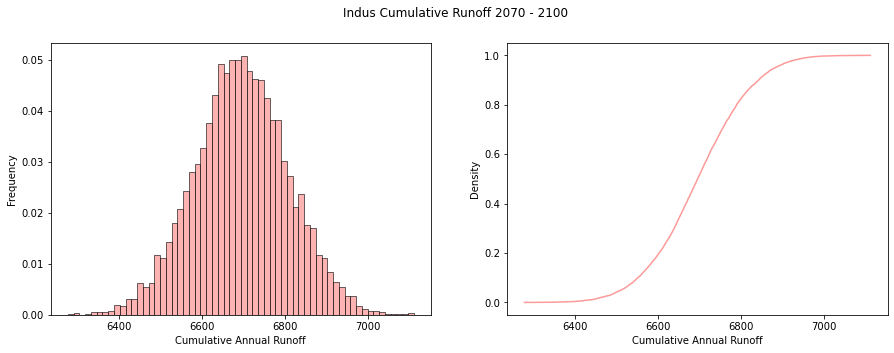

In [7]:
#calculate cumulative
Qf_indus_sum = np.cumsum(Qf_indus,axis=0)
Qf_indus_sum = Qf_indus_sum[-1,:]

Qf_indus_sum = pd.DataFrame(Qf_indus_sum,columns=['val'])
Qf_indus_sum = Qf_indus_sum.sort_values(by='val',ascending=True)
Qf_indus_sum = Qf_indus_sum.reset_index()
Qf_indus_sum['val_rank'] = Qf_indus_sum.index + 1 
Qf_indus_sum['prob'] = Qf_indus_sum['val_rank']/len(Qf_indus_sum)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))

sns.histplot(Qf_indus_sum.val,stat='probability',ax=ax1,color=cpal[4])
ax1.set_xlabel('Cumulative Annual Runoff')
ax1.set_ylabel('Frequency')

sns.lineplot(data=Qf_indus_sum,x='val',y='prob',ax=ax2,color=cpal[4])
ax2.set_xlabel('Cumulative Annual Runoff')
ax2.set_ylabel('Density')

plt.suptitle('Indus Cumulative Runoff 2070 - 2100')


In [8]:
#pick evenly distributed 100 scenarios
gcam_ind = np.linspace(0,9999,100).astype(int)
Qf_selected = Qf_indus_sum.iloc[gcam_ind]

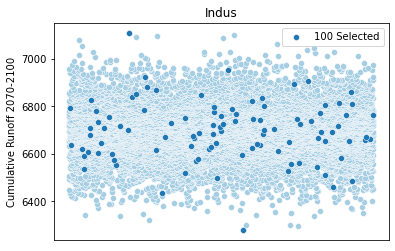

In [9]:
sns.scatterplot(data=Qf_indus_sum,x='index',y='val',color=cpal[0])
sns.scatterplot(data=Qf_selected,x='index',y='val',color=cpal[1],label='100 Selected')
plt.xlabel('Index')
plt.ylabel('Cumulative Runoff 2070-2100')
plt.title('Indus')
plt.xlabel('')
frame=plt.gca()
frame.axes.get_xaxis().set_visible(False)
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.savefig('scenarios_selected.pdf')

In [10]:
#generate CSVs for these scenarios
Q_gcam = Q[:,:,gcam_ind]

In [11]:
def generate_xml(q_det,Qf,m,id_list,name_list,fpath,spath):
    """This function generates CSVs for m stochastic realizations of runoff. 
    Inputs: q_det, deterministic xanthos historical runoff nyears x nbasins
            Qf: matrix of stochastic future runoff, nfyears x m x nbasins
            m: # realizations to generate XMLs for
            
    Returns: saves CSV that can be easily made into XML using csv_to_xml.R"""
    
    for i in range(m):    #for a given realization
        Q_mod = np.concatenate((q_det[nyears-5:,:],Qf[:,:,i]))#combine deterministic historical last 5 years with stochastic runoff
        Q_ma = pd.DataFrame(Q_mod).rolling(5).mean() #calculate backwards rolling mean
        Q_ma = Q_ma.iloc[5:,:] #start with value in 2020
        Q_ma = Q_ma.to_numpy()
        
        conv_Q = pd.DataFrame() #empty dataframe
        conv_Q['basin_id'] = id_list
        conv_Q['basin_name'] = name_list
        
        Q_scen = pd.DataFrame(Q_ma[::5,:]) #select every 5 years from rolling mean
        Q_scen = Q_scen.T
        conv_Q = pd.concat([conv_Q,Q_scen],axis=1) #add to larger matrix

        # create list of column names for the years
        yrs = np.linspace(2020,2100,17).astype(int)
        col_names = conv_Q.columns[2:].to_numpy()
        col_dict = dict(zip(col_names,yrs))

        conv_Q = conv_Q.rename(columns=col_dict) #rename columns
        conv_Q = conv_Q.melt(id_vars=['basin_id','basin_name'],var_name='year',
                            value_name = 'maxSubResource') # restructure dataframe to appropriate format for xml
        
        #load in mapping CSVs - this is so we are assigning the correct region
        basinid_gluname = pd.read_csv(fpath+'basin_to_country_mapping.csv')
        gluname_region = pd.read_csv(fpath+'basin_to_region_mapping.csv')

        #make dictionaries
        bname_dict = dict(zip(basinid_gluname.GCAM_basin_ID,
                             basinid_gluname.GLU_name))
        basreg_dict = dict(zip(gluname_region.gcam_basin_name,
                               gluname_region.region))
        
        
        conv_Q['renewresource'] = conv_Q['basin_id'].map(bname_dict)
        conv_Q['region'] = conv_Q['renewresource'].map(basreg_dict)
        conv_Q['sub.renewable.resource'] = 'runoff'
        conv_Q['renewresource'] = conv_Q['renewresource'] + '_water withdrawals'
        conv_Q = conv_Q[~conv_Q.region.isna()]
        conv_Q = conv_Q.sort_values(by=['basin_id','year'])
        conv_Q = conv_Q.filter(['region','renewresource','sub.renewable.resource','year','maxSubResource'])
        
        conv_Q.set_index('region').to_csv(spath+'stochastic_runoff_'+str(i+1)+'.csv')

In [12]:
nbasins = len(hist.basin_name.unique())
m = 100
id_list = hist['basin_id'].unique()[:].astype(int)
name_list = hist['basin_name'].unique()[:].astype(str) 
mappath = '/cluster/tufts/lamontagnelab/abirnb01/GCIMS/Abby_paper/gswp3w5e5data_19012019/'
stochpath = '/cluster/tufts/lamontagnelab/abirnb01/GCIMS/Abby_paper/ensemble_final/stochastic_runoff_csv/'
q_det = np.reshape(hist.groupby(['basin_id'],group_keys=False)['q_det'].apply(lambda x:x).to_numpy(),
                   (nyears,nbasins),order='F')
generate_xml(q_det,Q_gcam[nyears:,:,:],m,id_list,name_list,mappath,stochpath)